In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
from datetime import datetime
import time
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_json('/Users/yuhanqi/MA/code/data/transformer/512/2019_cleaned_transformer_512_prediction.json')

In [3]:
print('Total number of reviews in 2019: ', len(data))
print(data.columns)

Total number of reviews in 2019:  524593
Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'restaurant', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'average_stars', 'review_count',
       'categories', 'year', 'cleaned_text', 'stars_bert_512',
       'stars_albert_512', 'stars_distilbert_512', 'stars_xlnet_512',
       'stars_roberta_512'],
      dtype='object')


In [4]:
data['year-month'] = pd.to_datetime(data['date']).dt.to_period('M')
data['year-month-week'] = pd.to_datetime(data['date']).dt.to_period('W')

In [5]:
cols = ['stars', 'stars_bert_512', 'stars_albert_512', 'stars_distilbert_512', 'stars_roberta_512', 'stars_xlnet_512']
def week_BSI(df_data, cols):
    df_BSI = pd.DataFrame()
    mse = pd.DataFrame(columns=['Model','MSE'])
    est = pd.DataFrame(columns=['Model','Underestimated', 'Overestimated'])
    for i in cols:
        BSI_positive = df_data[df_data[i]>3].groupby(pd.Grouper(key='date', freq='W'))[i].count().reset_index(name='count')
        BSI_negative = df_data[df_data[i]<3].groupby(pd.Grouper(key='date', freq='W'))[i].count().reset_index(name='count')
        BSI = pd.concat([BSI_positive['date'], BSI_positive['count'], BSI_negative['count']]
                        , axis = 1, keys=['date', 'positive_count', 'negative_count'])
        df_BSI[i] = np.log((1+BSI['positive_count'])/(1+BSI['negative_count']))
        if i == 'stars':
            df_BSI['date'] = BSI['date']
        else:
            mse = mse.append({'Model':i,'MSE':mean_squared_error(df_BSI['stars'], df_BSI[i])}, ignore_index = True)
            est = est.append({'Model':i, 'Underestimated':(df_BSI[i] - df_BSI['stars']).lt(0).sum()
                              , 'Overestimated':(df_BSI[i] - df_BSI['stars']).gt(0).sum()},ignore_index=True)
    return df_BSI, mse, est

In [6]:
def week_ASI(df_data, cols):
    df_ASI = pd.DataFrame()
    mse = pd.DataFrame(columns=['Model','MSE'])
    est = pd.DataFrame(columns=['Model','Underestimated', 'Overestimated'])
    for i in cols:
        ASI = df_data.groupby(pd.Grouper(key='date', freq='W'))[i].mean().reset_index()
        df_ASI[i] = ASI[i]
        if i == 'stars':
            df_ASI['date'] = ASI['date']
        else:
            mse = mse.append({'Model':i,'MSE':mean_squared_error(df_ASI['stars'], df_ASI[i])}, ignore_index = True)
            est = est.append({'Model':i, 'Underestimated':(df_ASI[i] - df_ASI['stars']).lt(0).sum()
                              , 'Overestimated':(df_ASI[i] - df_ASI['stars']).gt(0).sum()},ignore_index=True)
    return df_ASI, mse, est

In [7]:
def week_VSI(df_data, cols):
    df_VSI = pd.DataFrame()
    mse = pd.DataFrame(columns=['Model','MSE'])
    est = pd.DataFrame(columns=['Model','Underestimated', 'Overestimated'])
    for i in cols:
        VSI = df_data.groupby(pd.Grouper(key='date', freq='W'))[i].var().reset_index()
        df_VSI[i] = VSI[i]
        if i == 'stars':
            df_VSI['date'] = VSI['date']
        else:
            mse = mse.append({'Model':i,'MSE':mean_squared_error(df_VSI['stars'], df_VSI[i])}, ignore_index = True)
            est = est.append({'Model':i, 'Underestimated':(df_VSI[i] - df_VSI['stars']).lt(0).sum()
                              , 'Overestimated':(df_VSI[i] - df_VSI['stars']).gt(0).sum()},ignore_index=True)
    return df_VSI, mse, est

In [8]:
def si_plot(df, y_min, y_max, ylabel, loc):
    plot = df.set_index('date') 
    plot.loc[:, plot.columns!="stars"].plot(label='stars',  marker='o'
                                            , color=['green', 'orange', 'purple', 'red', 'grey'], figsize=(12,4))
    plot.stars.plot(marker='o', color=['blue'], lw=5, alpha=0.5)
    plt.ylim(y_min, y_max)
    # adding title
    # plt.title('BSI Time Series of Sentiment (Star Rating) - 2019 Philadelphia', fontsize=16)
    # adding label to x-axis
    plt.xlabel('Week', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # adding legend.
    plt.legend(loc=loc)

# Philadelphia

In [9]:
philadelphia = data[data['city']=='Philadelphia']

In [10]:
phil_BSI, phil_BSI_mse, phil_BSI_est = week_BSI(philadelphia, cols)

In [11]:
phil_BSI_est

,Model,Underestimated,Overestimated
0,stars_bert_512,53,0
1,stars_albert_512,51,2
2,stars_distilbert_512,53,0
3,stars_roberta_512,24,29
4,stars_xlnet_512,51,2


In [12]:
phil_BSI_mse

,Model,MSE
0,stars_bert_512,0.008591
1,stars_albert_512,0.006574
2,stars_distilbert_512,0.00913
3,stars_roberta_512,0.001302
4,stars_xlnet_512,0.004718


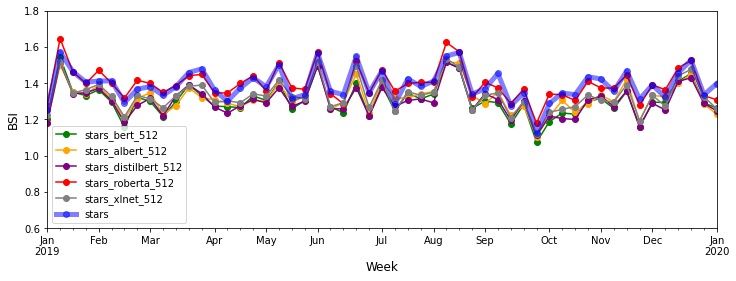

In [13]:
si_plot(phil_BSI, 0.6, 1.8, 'BSI', 'lower left')

In [14]:
phil_ASI, phil_ASI_mse, phil_ASI_est = week_ASI(philadelphia, cols)

In [15]:
phil_ASI_mse

,Model,MSE
0,stars_bert_512,0.000444
1,stars_albert_512,0.000883
2,stars_distilbert_512,0.000607
3,stars_roberta_512,0.000361
4,stars_xlnet_512,0.000268


In [16]:
phil_ASI_est

,Model,Underestimated,Overestimated
0,stars_bert_512,18,34
1,stars_albert_512,47,6
2,stars_distilbert_512,10,43
3,stars_roberta_512,17,34
4,stars_xlnet_512,28,25


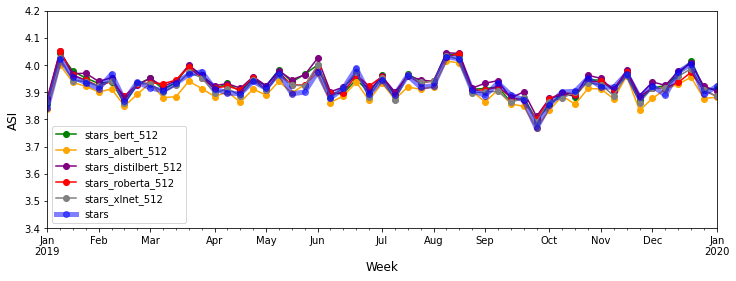

In [17]:
si_plot(phil_ASI, 3.4, 4.2, 'ASI', 'lower left')

In [18]:
phil_VSI, phil_VSI_mse, phil_VSI_est = week_VSI(philadelphia, cols)

In [19]:
phil_VSI_mse

,Model,MSE
0,stars_bert_512,0.01904
1,stars_albert_512,0.003962
2,stars_distilbert_512,0.016453
3,stars_roberta_512,0.003653
4,stars_xlnet_512,0.017173


In [20]:
phil_VSI_est

,Model,Underestimated,Overestimated
0,stars_bert_512,0,53
1,stars_albert_512,5,48
2,stars_distilbert_512,0,53
3,stars_roberta_512,47,6
4,stars_xlnet_512,0,53


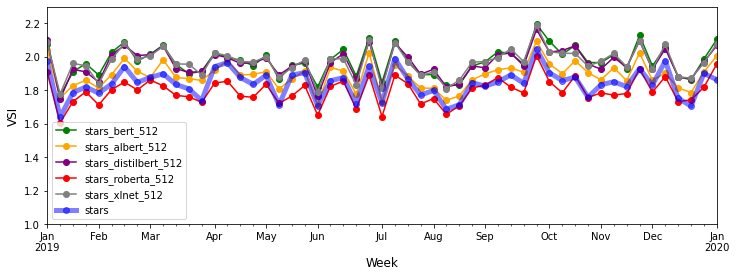

In [21]:
si_plot(phil_VSI, 1, 2.3, 'VSI', 'lower left')

# New Orleans

In [22]:
orleans = data[data['city']=='New Orleans']

In [23]:
new_BSI, new_BSI_mse, new_BSI_est = week_BSI(orleans, cols)

In [24]:
new_BSI_mse

,Model,MSE
0,stars_bert_512,0.009037
1,stars_albert_512,0.006278
2,stars_distilbert_512,0.010591
3,stars_roberta_512,0.002289
4,stars_xlnet_512,0.005728


In [25]:
new_BSI_est

,Model,Underestimated,Overestimated
0,stars_bert_512,52,1
1,stars_albert_512,48,5
2,stars_distilbert_512,51,2
3,stars_roberta_512,24,29
4,stars_xlnet_512,47,5


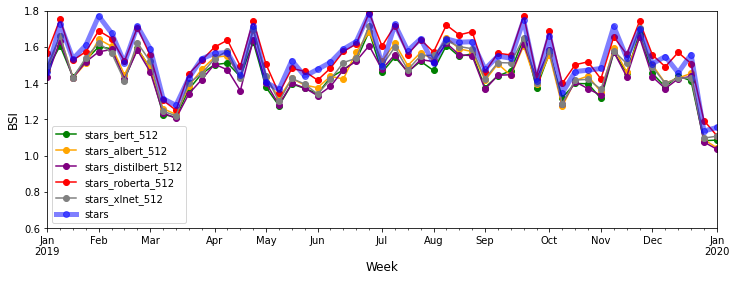

In [26]:
si_plot(new_BSI, 0.6, 1.8, 'BSI', 'lower left')

In [27]:
new_ASI, new_ASI_mse, new_ASI_est = week_ASI(orleans, cols)

In [28]:
new_ASI_mse

,Model,MSE
0,stars_bert_512,0.001035
1,stars_albert_512,0.000449
2,stars_distilbert_512,0.001459
3,stars_roberta_512,0.001191
4,stars_xlnet_512,0.000751


In [29]:
new_ASI_est

,Model,Underestimated,Overestimated
0,stars_bert_512,5,47
1,stars_albert_512,30,22
2,stars_distilbert_512,3,48
3,stars_roberta_512,3,50
4,stars_xlnet_512,10,43


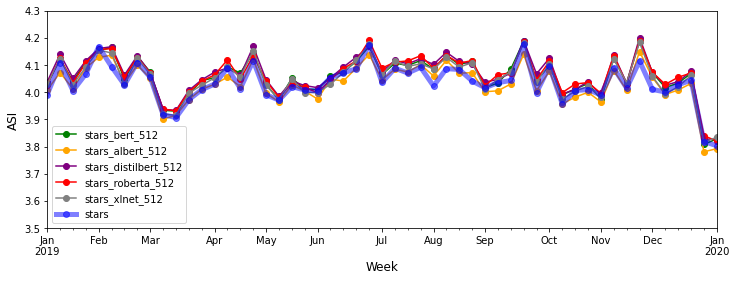

In [30]:
si_plot(new_ASI, 3.5, 4.3, 'ASI', 'lower left')

In [31]:
new_VSI, new_VSI_mse, new_VSI_est = week_VSI(orleans, cols)

In [32]:
new_VSI_mse

,Model,MSE
0,stars_bert_512,0.014559
1,stars_albert_512,0.003926
2,stars_distilbert_512,0.013656
3,stars_roberta_512,0.003916
4,stars_xlnet_512,0.013705


In [33]:
new_VSI_est

,Model,Underestimated,Overestimated
0,stars_bert_512,0,53
1,stars_albert_512,5,48
2,stars_distilbert_512,0,53
3,stars_roberta_512,48,5
4,stars_xlnet_512,0,53


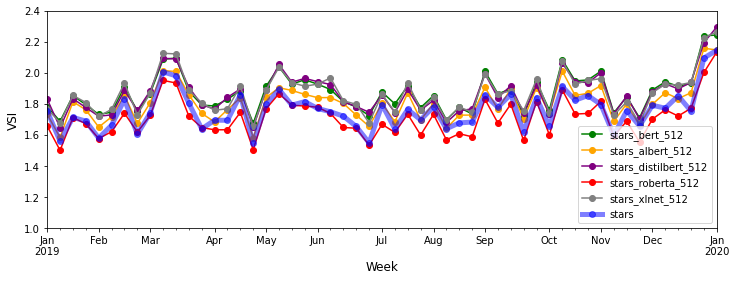

In [34]:
si_plot(new_VSI, 1, 2.4, 'VSI', 'lower right')

# Nashville

In [35]:
nashville = data[data['city']=='Nashville']

In [36]:
nash_BSI, nash_BSI_mse, nash_BSI_est = week_BSI(nashville, cols)

In [37]:
nash_BSI_mse

,Model,MSE
0,stars_bert_512,0.00751
1,stars_albert_512,0.005291
2,stars_distilbert_512,0.008016
3,stars_roberta_512,0.002441
4,stars_xlnet_512,0.005516


In [38]:
nash_BSI_est

,Model,Underestimated,Overestimated
0,stars_bert_512,51,2
1,stars_albert_512,47,6
2,stars_distilbert_512,51,2
3,stars_roberta_512,20,32
4,stars_xlnet_512,47,6


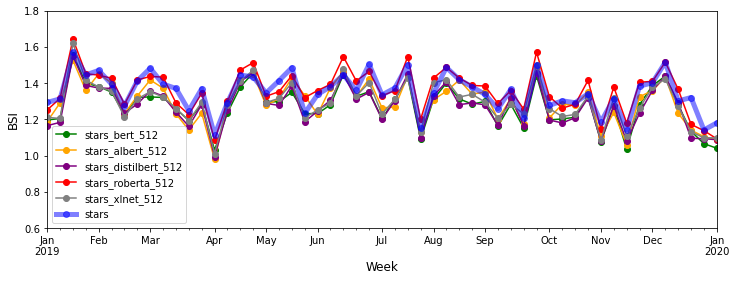

In [39]:
si_plot(nash_BSI, 0.6, 1.8, 'BSI', 'lower left')

In [40]:
nash_ASI, nash_ASI_mse, nash_ASI_est = week_ASI(nashville, cols)

In [41]:
nash_ASI_mse

,Model,MSE
0,stars_bert_512,0.000684
1,stars_albert_512,0.000662
2,stars_distilbert_512,0.00101
3,stars_roberta_512,0.001
4,stars_xlnet_512,0.000639


In [42]:
nash_ASI_est

,Model,Underestimated,Overestimated
0,stars_bert_512,16,35
1,stars_albert_512,34,18
2,stars_distilbert_512,12,38
3,stars_roberta_512,12,40
4,stars_xlnet_512,24,28


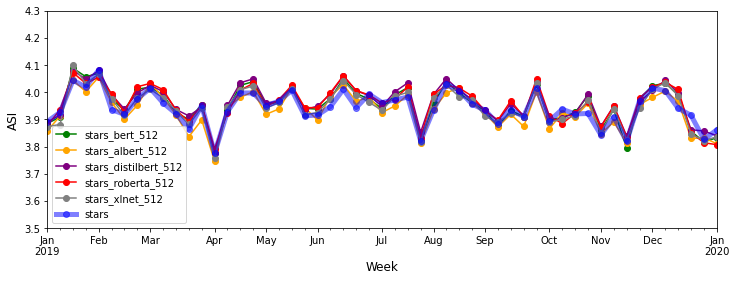

In [43]:
si_plot(nash_ASI, 3.5, 4.3, 'ASI', 'lower left')

In [44]:
nash_VSI, nash_VSI_mse, nash_VSI_est = week_VSI(nashville, cols)

In [45]:
nash_VSI_mse

,Model,MSE
0,stars_bert_512,0.017428
1,stars_albert_512,0.004842
2,stars_distilbert_512,0.015145
3,stars_roberta_512,0.004379
4,stars_xlnet_512,0.014214


In [46]:
nash_VSI_est

,Model,Underestimated,Overestimated
0,stars_bert_512,0,53
1,stars_albert_512,12,41
2,stars_distilbert_512,0,53
3,stars_roberta_512,44,9
4,stars_xlnet_512,1,52


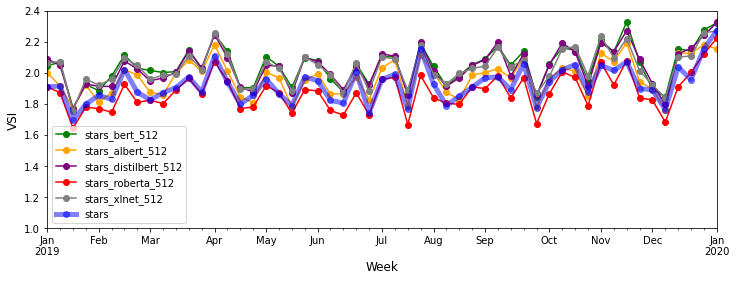

In [47]:
si_plot(nash_VSI, 1, 2.4, 'VSI', 'lower left')